# SVM and SHAP values for Discovery cohort

Written by: Youness Azimzade

email: younessazimzade@gmail.com

Latest update: 28/07/2023

In [2]:
# Import the required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import pylab as pl
import matplotlib.pyplot as plt

# Ensure the plots are displayed inline within the Jupyter notebook (if you are using one)
%matplotlib inline

# Load the data from the CSV file into a Pandas DataFrame
# Make sure to replace "~/AllSamplesCellFractionsAveraged10SM.csv" with the correct file path if needed
#data2 = pd.read_csv("~/AllSamplesCellFractionsAveraged10SM.csv")
data2 = pd.read_csv("E:/Dropbox (UiO)/Validation/AllSamples.csv")

# Display the first few rows of the DataFrame to check if the data is loaded correctly
data2.head()


,Trial,Mixture,B.cells.Memory,B.cells.Naive,CAFs.MSC.iCAF.like,CAFs.myCAF.like,DCs,Endothelial.ACKR1,Endothelial.CXCL12,Endothelial.LYVE1,...,TCells,Myeloids,BCells,CAFs,PVLs,Endothelials,ER,PAM50,Response,Cohort
0,GSE22093,GSM549230,0.017895,0.005095,0.029985,0.086698,0.015332,0.004916,0.117291,0.007518,...,0.200244,0.091443,0.022990,0.116683,0.039040,0.164980,Negative,Basal,pCR,Discovery
1,GSE22093,GSM549231,0.001398,0.030779,0.011099,0.115468,0.007091,0.003519,0.029935,0.002120,...,0.231807,0.124711,0.032177,0.126567,0.024725,0.064267,Negative,Her2,pCR,Discovery
2,GSE22093,GSM549232,0.001909,0.012753,0.000000,0.051034,0.003823,0.000000,0.002719,0.000241,...,0.027720,0.061014,0.014662,0.051034,0.016053,0.054086,Positive,Basal,pCR,Discovery
3,GSE22093,GSM549233,0.000000,0.008309,0.002679,0.086790,0.000110,0.000000,0.022606,0.001387,...,0.101619,0.134695,0.008309,0.089469,0.010784,0.059115,Negative,Basal,RD,Discovery
4,GSE22093,GSM549234,0.000000,0.009694,0.000000,0.060985,0.038723,0.000000,0.001546,0.000000,...,0.078525,0.111366,0.009694,0.060985,0.004148,0.068835,Negative,Basal,RD,Discovery


In [3]:
# Assuming you have already imported the required libraries like pandas
import pandas as pd

# Assuming you have loaded your data into the variable `data2` before this code segment

# Assigning the variable 'data2' to another variable 'data'
data = data2

# Mapping the values in the 'Response' column to binary values 0 and 1
resp = {'pCR': 1, 'RD': 0}
data.Response = [resp[item] for item in data.Response]

# Mapping the values in the 'ER' column to binary values 0 and 1
er = {'Positive': 1, 'Negative': 0}
data.ER = [er[item] for item in data.ER]

# Creating dummy variables for the categorical column 'PAM50'
categorical_cols = ['PAM50']
data = pd.get_dummies(data, columns=categorical_cols)

# Selecting discovery cohort data

data = data[data['Trial'].isin(['E-MTAB-4439', 'GSE18728', 'GSE19697', 'GSE20194', 'GSE20271', 'GSE22093', 'GSE22358', 'GSE42822', 'GSE22513'])]

# This line can be used to select validation cohort
#data = data[data['Trial'].isin(['GSE25066', 'GSE32603', 'GSE32646', 'GSE37946', 'GSE50948', 'GSE23988'])]

# Saving the modified data to a CSV file named 'DiscoveryData.csv' which is available on github with the same name
data.to_csv('~/DiscoveryData.csv')

# Printing the shape (number of rows and columns) of the final 'data' DataFrame
print(data.shape)


(1009, 46)


# Preprocessing 

In [4]:
# Import the necessary libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
from sklearn import preprocessing

 
# Extract the features (independent variables) and create a DataFrame 'X'
# Drop the columns 'Trial', 'Mixture', 'Response', and 'Cohort' from the data to get the features
X = pd.DataFrame(data.drop(['Trial', 'Mixture', 'Response', 'Cohort'], axis=1))

# Create a copy of 'X' in DataFrame 'd3' (later to be used in SHAP analysis)
d3 = pd.DataFrame(data.drop(['Trial', 'Mixture', 'Response', 'Cohort'], axis=1))

# Extract the target variable 'y' (dependent variable) from the 'data' DataFrame
y = data['Response']

# Perform standardization on the features using the StandardScaler from sklearn
# This step scales the features to have mean 0 and standard deviation 1
# This is important for some machine learning algorithms that are sensitive to feature scales
X = pd.DataFrame(preprocessing.StandardScaler().fit(X).transform(X), columns=d3.columns)

# Print the shape of the 'X' DataFrame (number of rows and columns)
print("Shape of X:", X.shape)


Shape of X: (1009, 42)


# Support Vector Machine

GridSearch

In [5]:
# Import necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer, f1_score, accuracy_score
from sklearn.model_selection import train_test_split


# Defining the parameter range for the hyperparameter grid search
param_grid = {
    'C': np.exp(np.linspace(-12, 3, num=50)),
    'gamma': np.exp(np.linspace(-12, 1, num=50)),
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

# Define a custom scoring dictionary that includes F1 score and accuracy
scoring = {
    'F1': make_scorer(f1_score),
    'Accuracy': make_scorer(accuracy_score)
}

# Create a StratifiedKFold object with 5 splits for cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# Split the dataset into training and testing sets using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3333)  # Make sure to import `train_test_split` before using it.

# Create a GridSearchCV object with the SVC classifier, parameter grid, custom scoring, refit based on F1 score, 10-fold cross-validation, and no verbosity
grid = GridSearchCV(SVC(class_weight='balanced'), param_grid, scoring=scoring, refit='F1', verbose=0, cv=10)

# Fit the model for grid search using the training data
grid.fit(X_train, y_train)

# Print the best parameters found during grid search
print(grid.best_params_)

# Print the best estimator (model) found during grid search
print(grid.best_estimator_)


{'C': 20.085536923187668, 'gamma': 0.007932915202908394, 'kernel': 'rbf'}
SVC(C=20.085536923187668, class_weight='balanced', gamma=0.007932915202908394)


Evaluating the performance of the best model and improving it by fine tuning

In [6]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import svm

#clf=grid.best_estimator_   ## We normally start with model that has best performance and
# fine tune the parameters to find the best model. Here the following model found to have the best performance
#  based on combined score
clf=svm.SVC(C=1,gamma=0.1,kernel='rbf',probability=True,class_weight='balanced')# #  It should be noted that 
# SHAP values calculated using these two models are very similar, particularly for features with high correlation
#  to response. 

cv = KFold(n_splits=5, random_state=1, shuffle=True)
# create model
model = clf #svm.SVC(C=1,kernel='linear',probability=True)
# evaluate model
Acc_score = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
f1_score = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1)
roc_auc = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)

# report performance
print('Accuracy: %.3f (%.3f)' % (mean(Acc_score)*100, std(Acc_score)*100))
print('f1 score: %.3f (%.3f)' % (mean(f1_score), std(f1_score)))
print('AUC: %.3f (%.3f)' % (mean(roc_auc), std(roc_auc)))


Accuracy: 75.525 (2.707)
f1 score: 0.429 (0.036)
AUC: 0.724 (0.025)


 # SHAP Analysis

In [19]:
!pip install shap
import shap


[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [20]:
# fitting the model to all discovery data 
clf.fit(X,y)

# creating the explainer using the model and X as the background
svm_explainer=shap.KernelExplainer(clf.predict,X)

# calculating SHAP values for X using the explainer
svm_shap_values=svm_explainer.shap_values(X) # For 1000 samples it takes 50 hours on a single core of 8gen intel CPU

X does not have valid feature names, but SVC was fitted with feature names
Using 1009 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
  0%|          | 0/1009 [00:00<?, ?it/s]X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set

In [21]:
svm_shap= pd.DataFrame(svm_shap_values,columns=d3.columns)
svm_shap.to_csv('~/DiscoverySHAP.csv') 

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


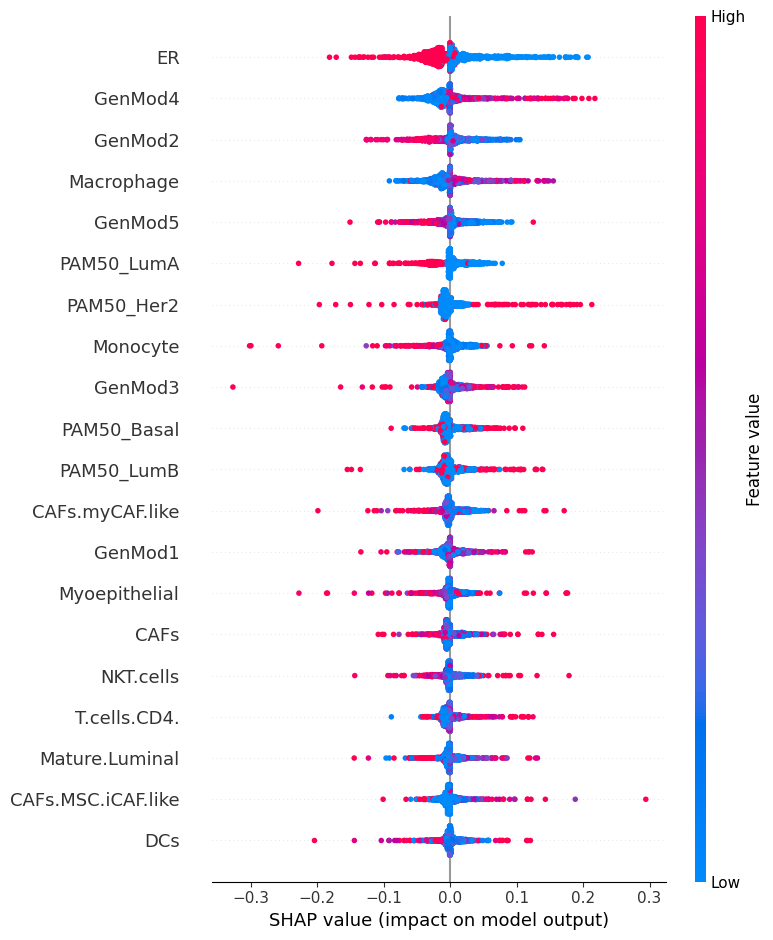

In [22]:
shap.summary_plot(svm_shap_values, X,feature_names=d3.columns)# ploting top 20 features based on their importance

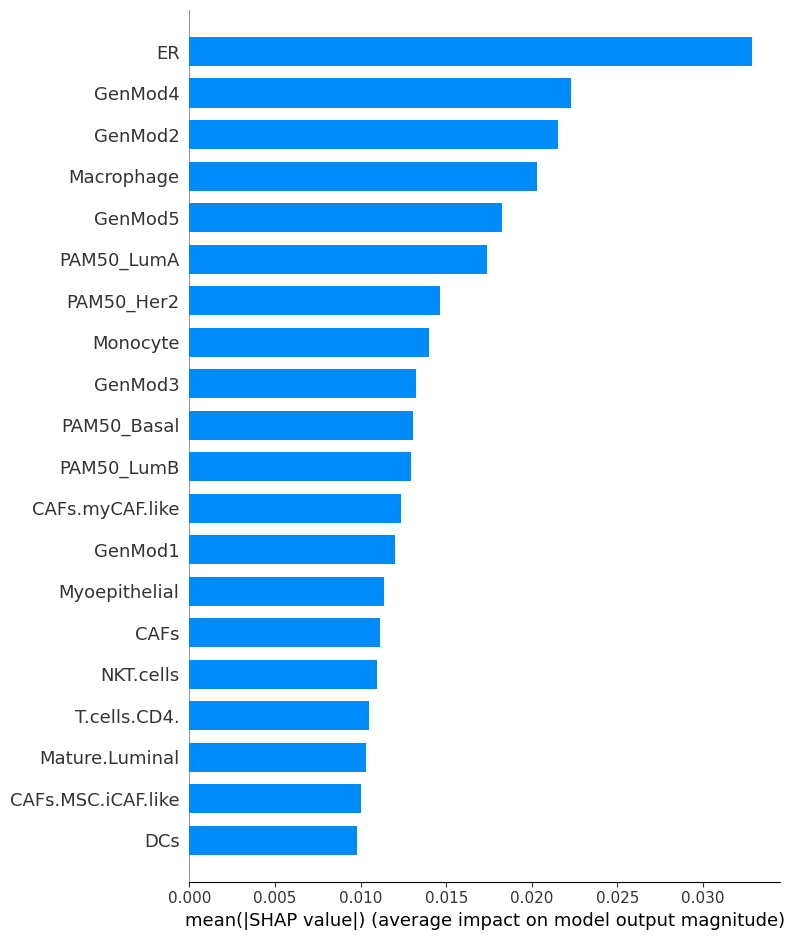

In [23]:
shap.summary_plot(svm_shap_values, X, feature_names=d3.columns, plot_type="bar")